# Data Cleaning

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import seaborn as sns
from scipy.stats import mode
from functools import reduce
from pykalman import KalmanFilter
import pmdarima as pm

ImportError: cannot import name 'huber_loss' from 'sklearn.metrics' (/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [282]:
DGS1 = pd.read_excel("DATA/DGS1.xls", skiprows=10)
DGS2 = pd.read_excel("DATA/DGS2.xls", skiprows=10)
DGS3MO   = pd.read_excel("DATA/DGS3MO.xls", skiprows=10)
DGS6MO  = pd.read_excel("DATA/DGS6MO.xls", skiprows=10)
DGS10= pd.read_excel("DATA/DGS10.xls", skiprows=10)
DGS3 = pd.read_excel("DATA/DGS3.xls", skiprows=10)
DGS5= pd.read_excel("DATA/DGS5.xls", skiprows=10)
DGS7= pd.read_excel("DATA/DGS7.xls", skiprows=10)


#Drop the 0 columns
DGS1 = DGS1[(DGS1 != 0.00).all(axis=1)]
DGS2 = DGS2[(DGS2 != 0.00).all(axis=1)]
DGS3MO = DGS3MO[(DGS3MO != 0.00).all(axis=1)]
DGS6MO = DGS6MO[(DGS6MO != 0.00).all(axis=1)]
DGS10 = DGS10[(DGS10 != 0.00).all(axis=1)]
DGS3 = DGS3[(DGS3 != 0.00).all(axis=1)]
DGS5 = DGS5[(DGS5 != 0.00).all(axis=1)]
DGS7 = DGS7[(DGS7 != 0.00).all(axis=1)]


2644
2535


In [21]:
index_comparison = {
    'DGS2': set(DGS1.index) == set(DGS2.index),
    'DGS3MO': set(DGS1.index) == set(DGS3MO.index),
    'DGS6MO': set(DGS1.index) == set(DGS6MO.index),
    'DGS10': set(DGS1.index) == set(DGS10.index),
    'DGS3': set(DGS1.index) == set(DGS3.index),
    'DGS5': set(DGS1.index) == set(DGS5.index),
    'DGS7': set(DGS1.index) == set(DGS7.index),
}

for df_name, comparison_result in index_comparison.items():
    print(f"{df_name} has the same indices as DGS1: {comparison_result}")


DGS2 has the same indices as DGS1: True
DGS3MO has the same indices as DGS1: False
DGS6MO has the same indices as DGS1: True
DGS10 has the same indices as DGS1: True
DGS3 has the same indices as DGS1: True
DGS5 has the same indices as DGS1: True
DGS7 has the same indices as DGS1: True


In [173]:
# Assume df1, df2, df3, ... are DataFrame objects you want to merge
dataframes = [DGS3MO, DGS1, DGS2, DGS6MO,DGS3, DGS5, DGS7,DGS10]

# Using reduce to merge multiple DataFrames on a common key
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date'), dataframes)

In [174]:
merged_df

observation_date  DGS3MO  DGS1  DGS2  DGS6MO  DGS3  DGS5  DGS7  DGS10
0          2014-01-02    0.07  0.13  0.39    0.09  0.76  1.72  2.41   3.00
1          2014-01-03    0.07  0.13  0.41    0.10  0.80  1.73  2.42   3.01
2          2014-01-06    0.05  0.12  0.40    0.08  0.78  1.70  2.38   2.98
3          2014-01-07    0.04  0.13  0.40    0.08  0.80  1.69  2.37   2.96
4          2014-01-08    0.05  0.13  0.43    0.08  0.87  1.77  2.44   3.01
...               ...     ...   ...   ...     ...   ...   ...   ...    ...
2517       2024-02-13    5.45  4.99  4.64    5.32  4.44  4.31  4.33   4.31
2518       2024-02-14    5.43  4.94  4.56    5.31  4.38  4.25  4.27   4.27
2519       2024-02-15    5.43  4.93  4.56    5.30  4.36  4.22  4.25   4.24
2520       2024-02-16    5.44  4.98  4.64    5.31  4.43  4.29  4.31   4.30
2521       2024-02-20    5.44  4.97  4.59    5.32  4.38  4.25  4.28   4.27

[2522 rows x 9 columns]

In [175]:
time_period = merged_df.iloc[:,0].values

In [176]:
time_period

array(['2014-01-02T00:00:00.000000000', '2014-01-03T00:00:00.000000000',
       '2014-01-06T00:00:00.000000000', ...,
       '2024-02-15T00:00:00.000000000', '2024-02-16T00:00:00.000000000',
       '2024-02-20T00:00:00.000000000'], dtype='datetime64[ns]')

# Task B

In [270]:
#Dummy eaxmple
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

#import numpy as np

def model(T, beta_0, beta_1, beta_2, lambd):
    term1 = (1 - np.exp(-lambd * T)) / (lambd * T)
    term2 = term1 - np.exp(-lambd * T)
    Y = beta_0 + beta_1 * term1 + beta_2 * term2
    return Y


x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])
y_data = np.array(merged_df.iloc[0][1:].values)

#params, _ = curve_fit(NS_model, x_data, y_data , p0=initial_guess ,maxfev=10000)
params, _ = curve_fit(model, x_data, y_data , p0=initial_guess ,maxfev=10000)

# print(params)
    
# Predict using the fitted model
y_pred = model(x_data, *params)
#_pred = model(y_data, *params)

mae = mean_absolute_error(y_data, y_pred)
mse = mean_squared_error(y_data, y_pred)

print(mse)
print(params)
print(y_pred)
print(y_data)

0.04699686054943067
[-2.93505792e+01  2.92266779e+01  1.05096571e+02  9.19443569e-03]
[-0.03686287  0.04985767  0.22234866  0.56355435  0.89977057  1.55745086
  2.19581671  3.11806443]
[0.07 0.13 0.39 0.09 0.76 1.72 2.41 3.0]


array([-0.03850091,  0.1482886 ,  0.47447538,  0.97285886,  1.31899914,
        1.72636899,  1.9228705 ,  2.04463807])

In [178]:
y_data

array([0.07, 0.13, 0.39, 0.09, 0.76, 1.72, 2.41, 3.0], dtype=object)

## Formulating Curve Fitting Problem

In [271]:
# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)

# Initialize a dictionary to hold the results
results = {}

# Your NS_model definition remains the same

# When calling curve_fit, add the bounds argument
# Set the bounds for [beta_0, beta_1, beta_2, lambda]
# Assuming you want all parameters to be free but lambda to be strictly positive,
# you can set the lower bounds for all parameters to -np.inf (or a sensible lower limit for each)
# and set the lower bound for lambda to a small positive number (e.g., 1e-6 to avoid zero and enforce positivity)
# Upper bounds are set to np.inf, which means no upper limit (or you can specify a sensible upper limit)

bounds = ([-np.inf, -np.inf, -np.inf, 1e-6], [np.inf, np.inf, np.inf, np.inf])

# Now include these bounds in your curve_fit call
# params, _ = curve_fit(NS_model, x_data, y_data, bounds=bounds, maxfev=10000)


# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    initial_guess = [1.0, 0.5, 0.3, 0.4]
    
    # Apply curve fit
    params, _ = curve_fit(model, x_data, y_data , p0=initial_guess ,maxfev=100000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = model(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    results[row] = {
        'Parameters': params,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
for column, metrics in results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
print(params)


/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_7622/3459210306.py:8: RuntimeWarning: overflow encountered in exp
  term1 = (1 - np.exp(-lambd * T)) / (lambd * T)
/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_7622/3459210306.py:9: RuntimeWarning: overflow encountered in exp
  term2 = term1 - np.exp(-lambd * T)
/var/folders/x4/4mqqdmr15ns_x0tn1xzv7q5h0000gn/T/ipykernel_7622/3459210306.py:9: RuntimeWarning: invalid value encountered in subtract
  term2 = term1 - np.exp(-lambd * T)


0:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-2.93505792e+01  2.92266779e+01  1.05096571e+02  9.19443569e-03]
  MAE: 0.18284728937698674
  MSE: 0.04699686054943067
  R2: 0.9597693662962531

1:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-1.65228588e+02  1.65108339e+02  2.61300105e+02  7.39883604e-03]
  MAE: 0.17726853529435624
  MSE: 0.04598680127518766
  R2: 0.9606664134337624

2:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-1.44832137e+02  1.44701947e+02  2.42706615e+02  7.14367189e-03]
  MAE: 0.1754534643100225
  MSE: 0.0455140200571001
  R2: 0.96049339182017

3:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-2.41954361e+02  2.41824275e+02  3.47319005e+02  6.68001537e-03]
  MAE: 0.17114848109414
  MSE: 0.04464098510739237
  R2: 0.9607201605982103

4:
  Parameters (beta_0,beta_1,beta_2, lmbda): [-6.28024886e+02  6.27888871e+02  7.51998001e+02  6.09018160e-03]
  MAE: 0.17610083447926217
  MSE: 0.04964901066162686
  R2: 0.9580939228337793

5:
  Parameters (beta_0,beta_1,beta_2, lmb

In [260]:
?curve_fit

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    *,
    full_output=False,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``.

Parameters
----------
f : callable
    The model function, f(x, ...). It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, and each element should be float
    convertible if it is an array like object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    Initial guess for the parameters (length N). If None, then the
    initia

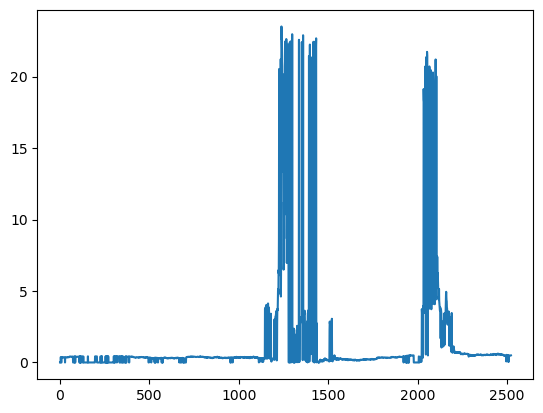

In [272]:
plt.plot(lambdas)

<Axes: >

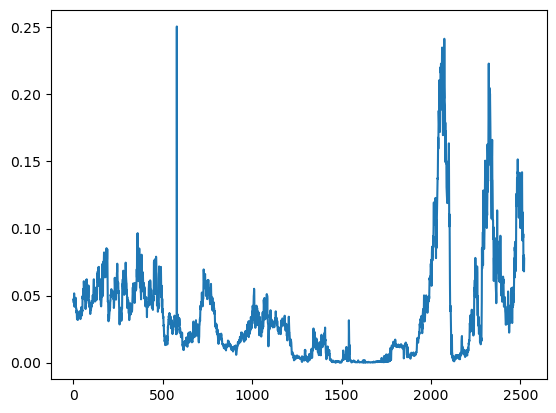

In [273]:
mse = [value['MSE'] for value in results.values()]
pd.Series(mse).plot()
#TODO:make this plot more beautiful

<Axes: >

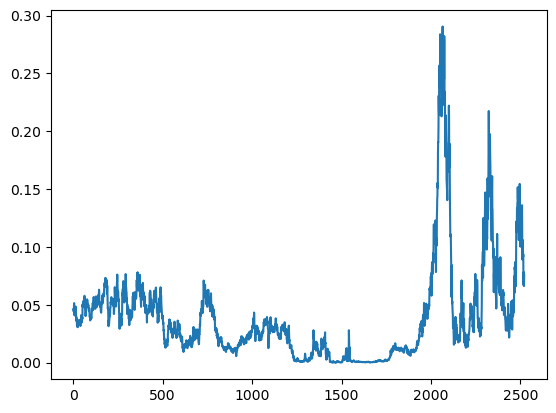

In [243]:
mse = [value['MSE'] for value in fix_lambda_results.values()]
pd.Series(mse).plot()

In [180]:
lambdas = [value['Parameters'][3] for value in results.values()]
beta_0 = [value['Parameters'][0] for value in results.values()]
beta_1 = [value['Parameters'][1] for value in results.values()]
beta_2 = [value['Parameters'][2] for value in results.values()]
#sns.distplot(lambdas, bins=1000)

In [181]:
np.min(lambdas)

-4.647178738446855e-05

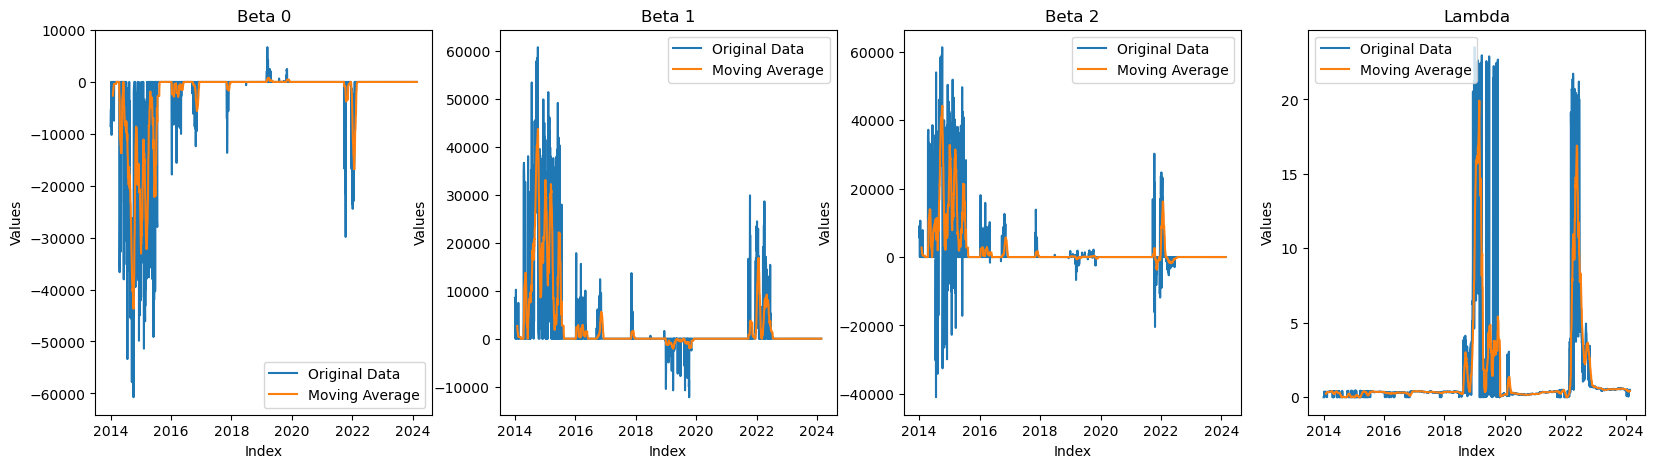

In [274]:
def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    plt.subplot(1, 4, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(beta_0, 1, 'Beta 0')
plotting_param(beta_1, 2, 'Beta 1')
plotting_param(beta_2, 3, 'Beta 2')  # Assuming you have beta_3
plotting_param(lambdas, 4, 'Lambda')  # Assuming you have beta_4
plt.show()


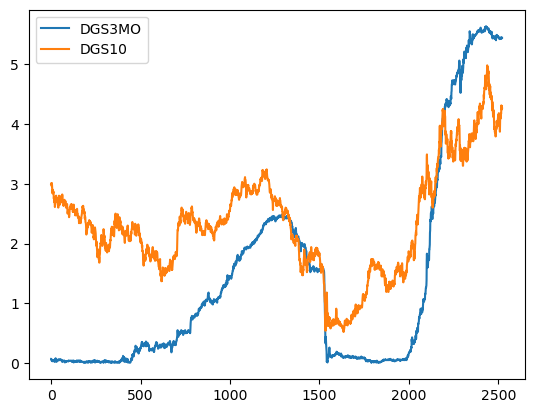

In [183]:
#merged_df.set_index('observation_date', inplace=True)
merged_df["DGS3MO"].plot()
#merged_df["DGS6MO"].plot()
#merged_df["DGS1"].plot()
#merged_df["DGS2"].plot()
#merged_df["DGS3"].plot()
#merged_df["DGS5"].plot()
#merged_df["DGS7"].plot()
merged_df["DGS10"].plot()
plt.legend()

## Optimal Lambda

<Axes: >

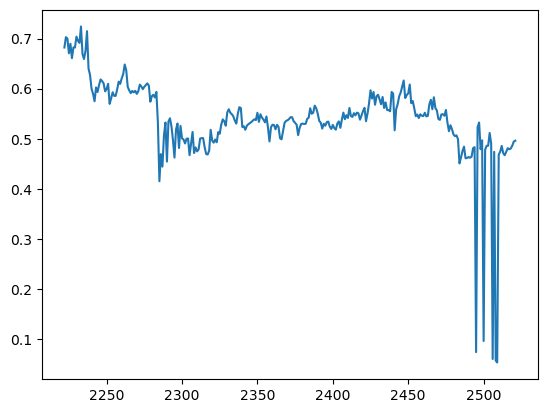

In [238]:
pd.Series(lambdas)[-300:].plot()

<Axes: >

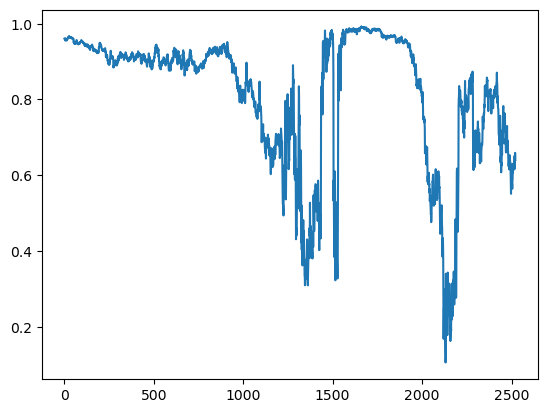

In [236]:
mse = [value['R2'] for value in fix_lambda_results.values()]
pd.Series(mse).plot()

1. What is our loss function
2. How do we cross validate in time series
3. compare cross-validation against vanilla method


In [280]:
rounded_lambdas =  [round(num, 1) for num in lambdas]
len(set(rounded_lambdas))
possible_values = []
for i in set(rounded_lambdas):
    if i > 0.0 and i < 1 :
        possible_values.append(i)

[0.25,
 0.75,
 3.74,
 3.33,
 3.84,
 6.47,
 3.41,
 3.01,
 3.25,
 3.34,
 4.77,
 6.23,
 6.24,
 8.68,
 8.61,
 9.29,
 9.71,
 6.5,
 0.5,
 1.25,
 2.36,
 2.5,
 0.21,
 3.5,
 3.0,
 7.47,
 0.42,
 0.46,
 0.17,
 4.69,
 4.94,
 5.19,
 0.13,
 0.38,
 0.59,
 0.63,
 0.67,
 2.66,
 2.41,
 3.16,
 3.66,
 0.27,
 0.77,
 0.52,
 7.16,
 1.02,
 8.66,
 3.52,
 0.09,
 1.13,
 2.38,
 2.13,
 2.88,
 3.38,
 3.63,
 3.88,
 4.13,
 4.38,
 5.88,
 0.34,
 0.3,
 4.1,
 0.05,
 0.01,
 0.26,
 0.47,
 1.97,
 1.05,
 1.68,
 0.8,
 0.72,
 0.76,
 0.51,
 0.55,
 4.07,
 4.32,
 0.22,
 0.79,
 0.54,
 2.79,
 3.79,
 3.29,
 3.54,
 6.54,
 2.9,
 2.65,
 0.43,
 0.18,
 2.26,
 2.76,
 3.76,
 3.51,
 4.51,
 5.26,
 6.26,
 0.14,
 0.35,
 0.39,
 0.93,
 0.68,
 0.64,
 0.6,
 4.73,
 8.7,
 0.1,
 2.45,
 2.7,
 2.95,
 3.7,
 3.45,
 4.2,
 0.81,
 0.56,
 2.31,
 2.81,
 3.56,
 3.06,
 0.74,
 0.31,
 0.06,
 1.17,
 2.92,
 3.42,
 3.67,
 3.17,
 4.67,
 2.78,
 2.03,
 3.78,
 3.28,
 3.03,
 4.14,
 0.02,
 5.14,
 0.73,
 0.48,
 2.93,
 3.6,
 3.47,
 2.86,
 3.43,
 3.18,
 3.86,
 3.4,
 3.9,
 3.

Try to design a systematic trading strategy based on the NS model. This is an open ended project and sky is the limit. It could, for exam- ple, go along the following lines.
(i) Calibrate the NS model for each of the days in your database, store the daily values of the parameters β1, β2, β3 and λ.

In [269]:
# Assuming NS_model is defined elsewhere
# Assuming results, merged_df, and rounded_lambdas are defined elsewhere

# Initialize a dictionary to hold the results
op_lam = {}
min_mse = float('inf')  # Using float('inf') is a more conventional way to initialize to infinity
min_mae = float('inf')
min_r2 = float('inf')

for lambda_opt in tqdm(possible_values, desc="Optimizing Lambda"):
    mae = 0
    mse = 0
    r2 = 0
    for row in range(len(merged_df)):  # Assuming merged_df is defined elsewhere
        y_data = merged_df.iloc[row].values[1:]
        x_data = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10])
        
        # Apply curve fit and predict (assuming NS_model and results are correctly defined)
            y_pred = model(x_data, results[row]['Parameters'][0], results[row]['Parameters'][1], results[row]['Parameters'][2], lambda_opt)
        
        # Calculate metrics
        mae += mean_absolute_error(y_data, y_pred)
        mse += mean_squared_error(y_data, y_pred)

    # Update minimum metrics and corresponding lambda
    if mse < min_mse:
        op_lam["mse"] = lambda_opt
        min_mse = mse
    if mae < min_mae:
        op_lam["mae"] = lambda_opt
        min_mae = mae
    
    

print(op_lam)


Optimizing Lambda:   4%|██████▌                                                                                                                                                        | 11/268 [00:06<02:38,  1.63it/s]


KeyboardInterrupt: 

In [191]:
op_lam

{'mse': 0.05, 'mae': 0.01}

In [256]:
op_lam_mse = 0.6

In [265]:
op_lam_mae = 0.01

Part B (ii) and (iii): Optimal Parameter Fitting for beta_0, beta_1 and beta_2

In [258]:
merged_df

observation_date  DGS3MO  DGS1  DGS2  DGS6MO  DGS3  DGS5  DGS7  DGS10
0          2014-01-02    0.07  0.13  0.39    0.09  0.76  1.72  2.41   3.00
1          2014-01-03    0.07  0.13  0.41    0.10  0.80  1.73  2.42   3.01
2          2014-01-06    0.05  0.12  0.40    0.08  0.78  1.70  2.38   2.98
3          2014-01-07    0.04  0.13  0.40    0.08  0.80  1.69  2.37   2.96
4          2014-01-08    0.05  0.13  0.43    0.08  0.87  1.77  2.44   3.01
...               ...     ...   ...   ...     ...   ...   ...   ...    ...
2517       2024-02-13    5.45  4.99  4.64    5.32  4.44  4.31  4.33   4.31
2518       2024-02-14    5.43  4.94  4.56    5.31  4.38  4.25  4.27   4.27
2519       2024-02-15    5.43  4.93  4.56    5.30  4.36  4.22  4.25   4.24
2520       2024-02-16    5.44  4.98  4.64    5.31  4.43  4.29  4.31   4.30
2521       2024-02-20    5.44  4.97  4.59    5.32  4.38  4.25  4.28   4.27

[2522 rows x 9 columns]

<Axes: >

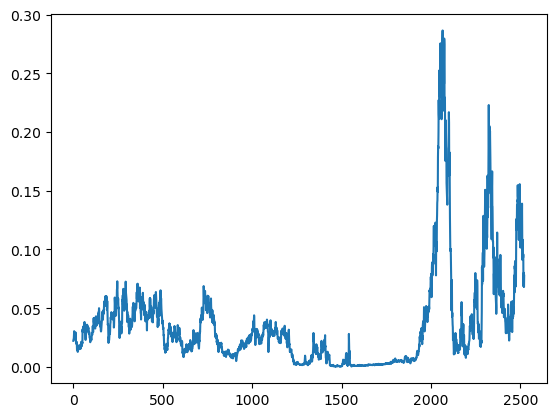

In [281]:
# Assuming `merged_df` is your DataFrame

# Define the model function; still using a linear function for demonstration
def NS_model(s, beta_0,beta_1,beta_2, lmbda):
    return beta_0 + beta_1 * np.exp(-lmbda*s) + beta_2*lmbda*s*np.exp(-lmbda*s)


def model_lambda_fixed(T, beta_0, beta_1, beta_2):
    lambd=0.6
    term1 = (1 - np.exp(-lambd * T)) / (lambd * T)
    term2 = term1 - np.exp(-lambd * T)
    Y = beta_0 + beta_1 * term1 + beta_2 * term2
    return Y
    
def NS_model_lambda_fixed(s, beta_0,beta_1,beta_2):
    return beta_0 + beta_1 * np.exp(-op_lam_mse*s) + beta_2*op_lam_mse*s*np.exp(-op_lam_mse*s)

# Initialize a dictionary to hold the results
fix_lambda_results = {}

# Iterate over each column, excluding 'observation_date'
for row in range(len(merged_df)):  # Excluding 'observation_date'
    y_data = merged_df.iloc[row].values[1:]
    x_data = np.array([0.25,0.5,1, 2, 3, 5, 7, 10])

    # print(x_data, y_data)
    
    # Apply curve fit
    params, _ = curve_fit(model_lambda_fixed, x_data, y_data,maxfev=100000)
    # print(params)
    
    # Predict using the fitted model
    y_pred = model_lambda_fixed(x_data, *params)
    
    # Calculate metrics
    mae = mean_absolute_error(y_data, y_pred)
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    # Store the results
    fix_lambda_results[row] = {
        'Parameters': params,
        'lambda': op_lam_mse,
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }

# Display the results for each column
"""

for column, metrics in fix_lambda_results.items():
    print(f"{column}:")
    print(f"  Parameters (beta_0,beta_1,beta_2, lmbda): {metrics['Parameters']}")
    print(f"  lambda: {metrics['lambda']}")
    print(f"  MAE: {metrics['MAE']}")
    print(f"  MSE: {metrics['MSE']}")
    print(f"  R2: {metrics['R2']}\n")
"""
#print(params)

mse = [value['MSE'] for value in fix_lambda_results.values()]
pd.Series(mse).plot()


## Plots for the Fixed Parameters

<Axes: >

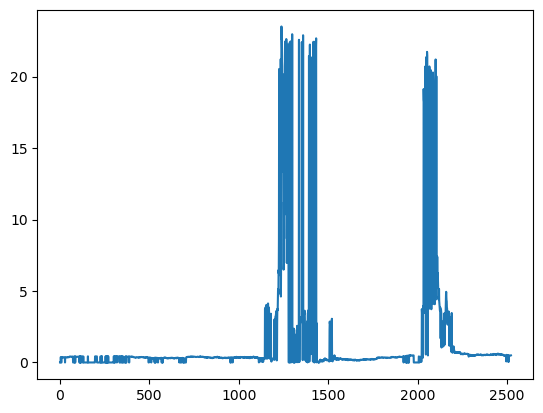

In [230]:
pd.Series(lambdas).plot()

In [223]:
#lambdas = [value['Parameters'][3] for value in results.values()]
fix_beta_0 = [value['Parameters'][0] for value in fix_lambda_results.values()]
fix_beta_1 = [value['Parameters'][1] for value in fix_lambda_results.values()]
fix_beta_2 = [value['Parameters'][2] for value in fix_lambda_results.values()]
#sns.distplot(lambdas, bins=1000)

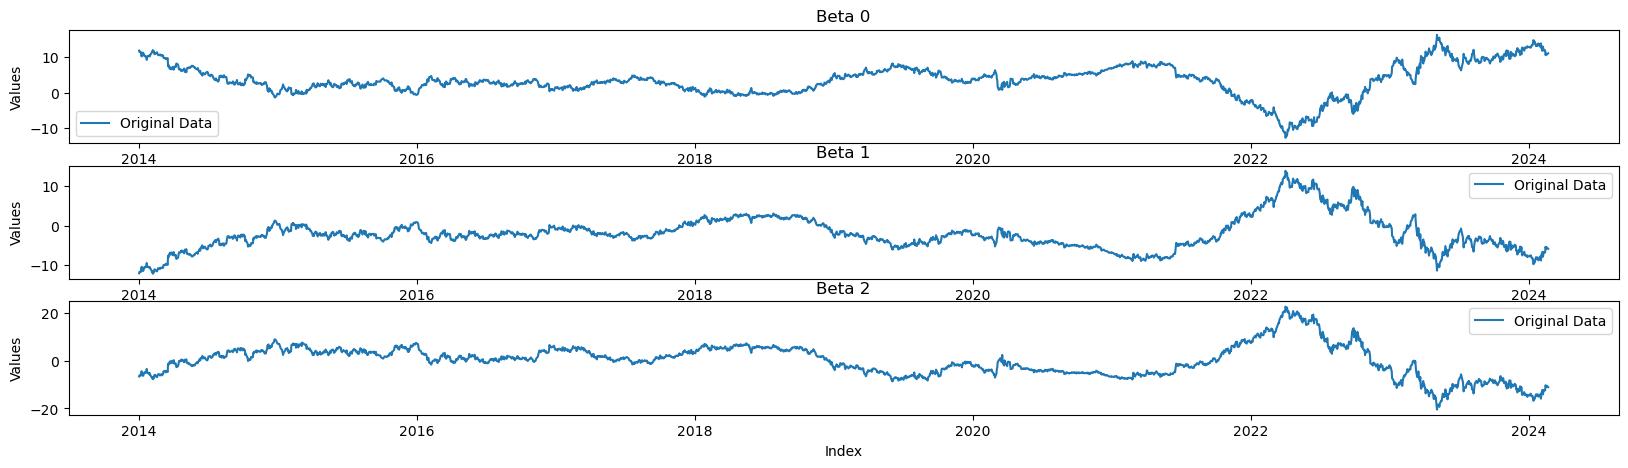

In [224]:
# Define the time range from the given start and end dates
#time_period

def plotting_param(list_plot, position, title):
    # Convert the dictionary of fourth elements into a pandas Series for easier handling
    lambdas_series = pd.Series(list_plot, index=time_period)
    
    # Calculate a simple moving average with a window of 2 for demonstration purposes
    #moving_average = lambdas_series.rolling(window=20).mean()
    
    # Plot the original data and moving average on the specified subplot position
    lambdas_series = pd.Series(list_plot, index=time_period)
    plt.subplot(3, 1, position)  # 1 row, 4 columns, current position
    plt.plot(lambdas_series, label='Original Data')
    #plt.plot(moving_average, label='Moving Average')
    plt.legend()
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Values')
    

# Assuming beta_1, beta_2, beta_3, beta_4 are defined
# You would call the function like this:
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plotting_param(fix_beta_0, 1, 'Beta 0')
plotting_param(fix_beta_1, 2, 'Beta 1')
plotting_param(fix_beta_2, 3, 'Beta 2')  # Assuming you have beta_3
plt.show()

# Task C: Alpha Research

## Calibration for the lambda model

In [124]:
lambdas

[0.36448319224456666,
 0.3740523632279524,
 0.38009844882873733,
 0.3827852520271077,
 0.37126576061852384,
 0.36794705009718015,
 0.3800924713807383,
 0.39191574169756893,
 0.3800672706642609,
 0.37477028517107325,
 0.37997425105473637,
 0.3826364429945354,
 0.37813605167452935,
 0.36965956960473845,
 0.37160674085226286,
 0.3779298854702717,
 0.36973920423854634,
 0.37739498426445844,
 0.3828599697167493,
 0.3773992417328413,
 0.38717776814002147,
 0.3783714392476303,
 0.37595275503518805,
 0.3702202384604242,
 0.3739737002130712,
 0.38580068715488897,
 0.39054803024886714,
 0.3910086046084935,
 0.38496995498380143,
 0.39442726850054816,
 0.3964587938594274,
 0.38522535882903153,
 0.38237011508794,
 0.3779782993593591,
 0.36972859747075937,
 0.37650843024762687,
 0.376834970596647,
 0.384060216752704,
 0.3815073812048266,
 0.37378943115025903,
 0.37937510005575487,
 0.37001111130170783,
 0.37360053533021537,
 0.3758846738471209,
 0.36574602104494935,
 0.367311471261024,
 0.3656152192

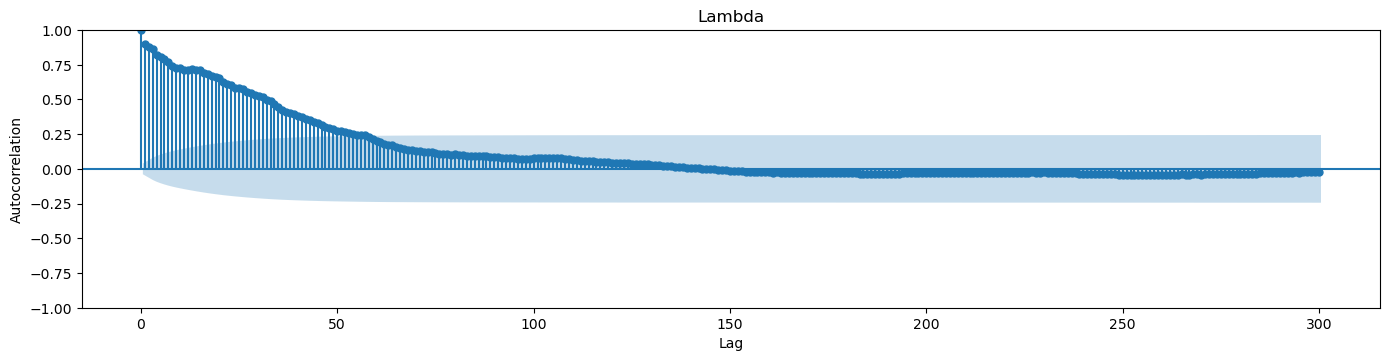

In [93]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(lambdas, 1, 'Lambda')
#plotting_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

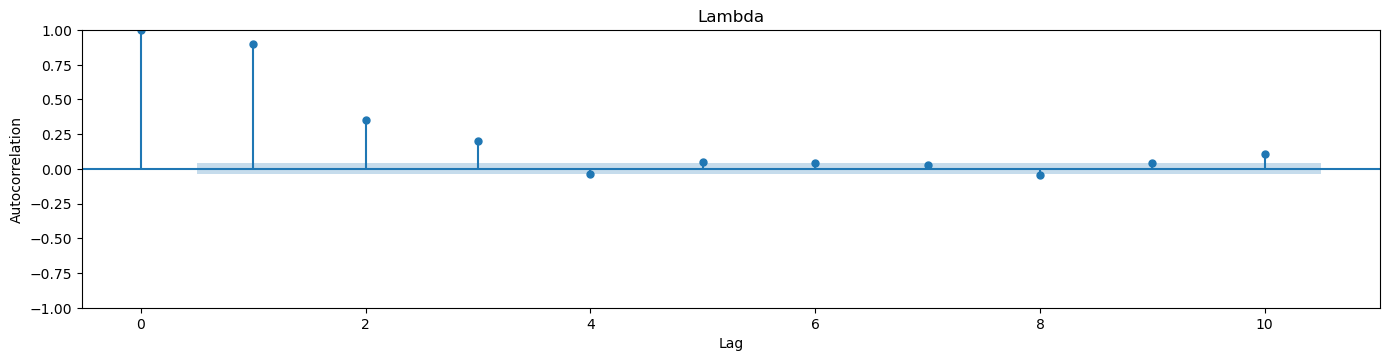

In [94]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=10, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(lambdas, 1, 'Lambda')
#plotting_partial_auto_correlation(beta_2, 2, 'Beta 2')
#plotting_partial_auto_correlation(beta_3, 3, 'Beta 3')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## PMD Auto Arima for Lambdas

In [109]:
arima_model_lambdas = pm.auto_arima(lambdas, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='bic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=8600.254, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=8088.018, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=8090.015, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=8090.130, Time=0.18 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=8040.711, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=8042.654, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=8200.507, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=8090.015, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=8067.873, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=8068.258, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=8042.615, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=8075.142, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=8075.599, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=8070.648, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=8070.571, Time=0.65 sec
 ARIMA(3,1

In [111]:
arima_model_lambdas = pm.auto_arima(fix_beta_0, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-8464.827, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-8463.728, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-8463.368, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-8461.467, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-8464.033, Time=0.70 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-8463.499, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-8463.680, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-8461.111, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-8460.267, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-8459.505, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-8462.774, Time=0.38 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-8463.473, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-8460.787, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-8480.687, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-8477.803, Time=0.96

In [110]:
arima_model_lambdas = pm.auto_arima(fix_beta_1, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=2147.635, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=2080.780, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=2082.729, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=2060.375, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=2043.943, Time=0.30 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=2034.445, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=2080.213, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=2082.207, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=2083.805, Time=0.36 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=2051.785, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=2017.171, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=2082.210, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=2065.337, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=2076.968, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=2056.782, Time=1.07 sec
 ARIMA(3,1

In [108]:
arima_model_lambdas = pm.auto_arima(fix_beta_2, trace=True,max_p=5,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=781.736, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=751.135, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=751.798, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=736.199, Time=0.29 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=727.541, Time=0.34 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=728.370, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=749.646, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=749.626, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=751.590, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=728.329, Time=0.69 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=716.602, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=750.290, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=751.606, Time=0.52 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=740.302, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=730.218, Time=0.78 sec
 ARIMA(3,1,0)(0,0,0)[1] i

<Axes: >

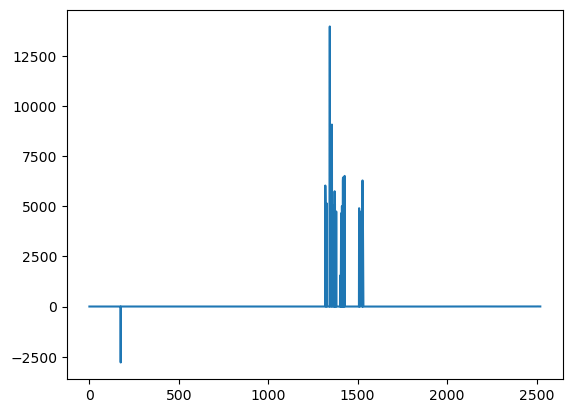

In [102]:
pd.Series(beta_0).plot()

## Time Series Properties

(ii) Investigate the statistical properties of the time series of these pa- rameters. Do they show any mean reversion properties, can they be modeled by any of the time series models (such as ARIMA)?

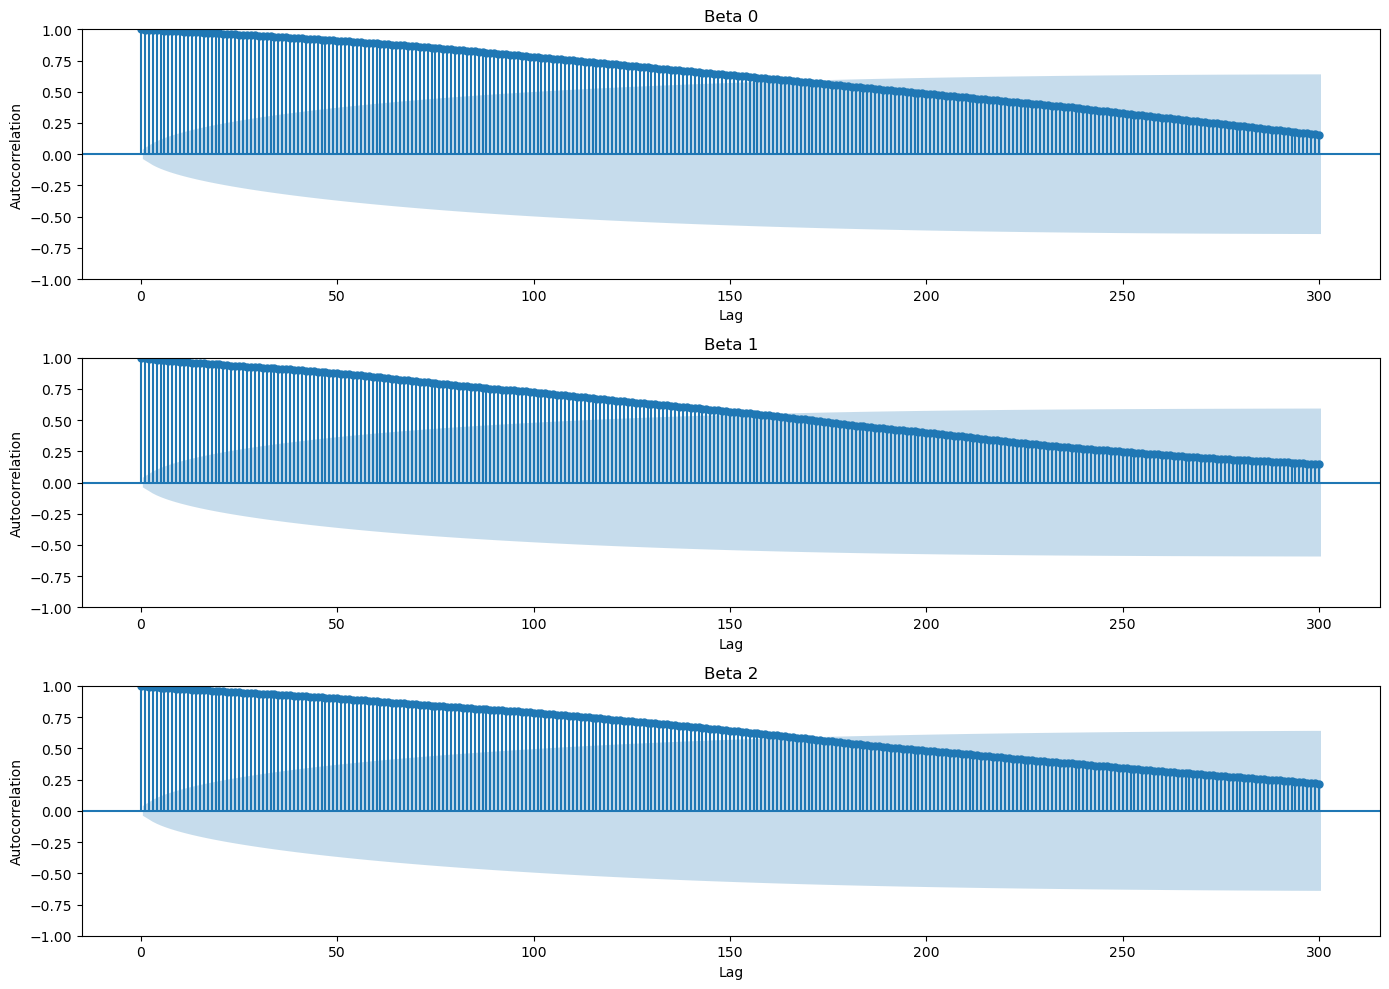

In [118]:
#check for autocorrelation
def plotting_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_acf(list_plot, lags=300, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_auto_correlation(fix_beta_0, 1, 'Beta 0')
plotting_auto_correlation(fix_beta_1, 2, 'Beta 1')
plotting_auto_correlation(fix_beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

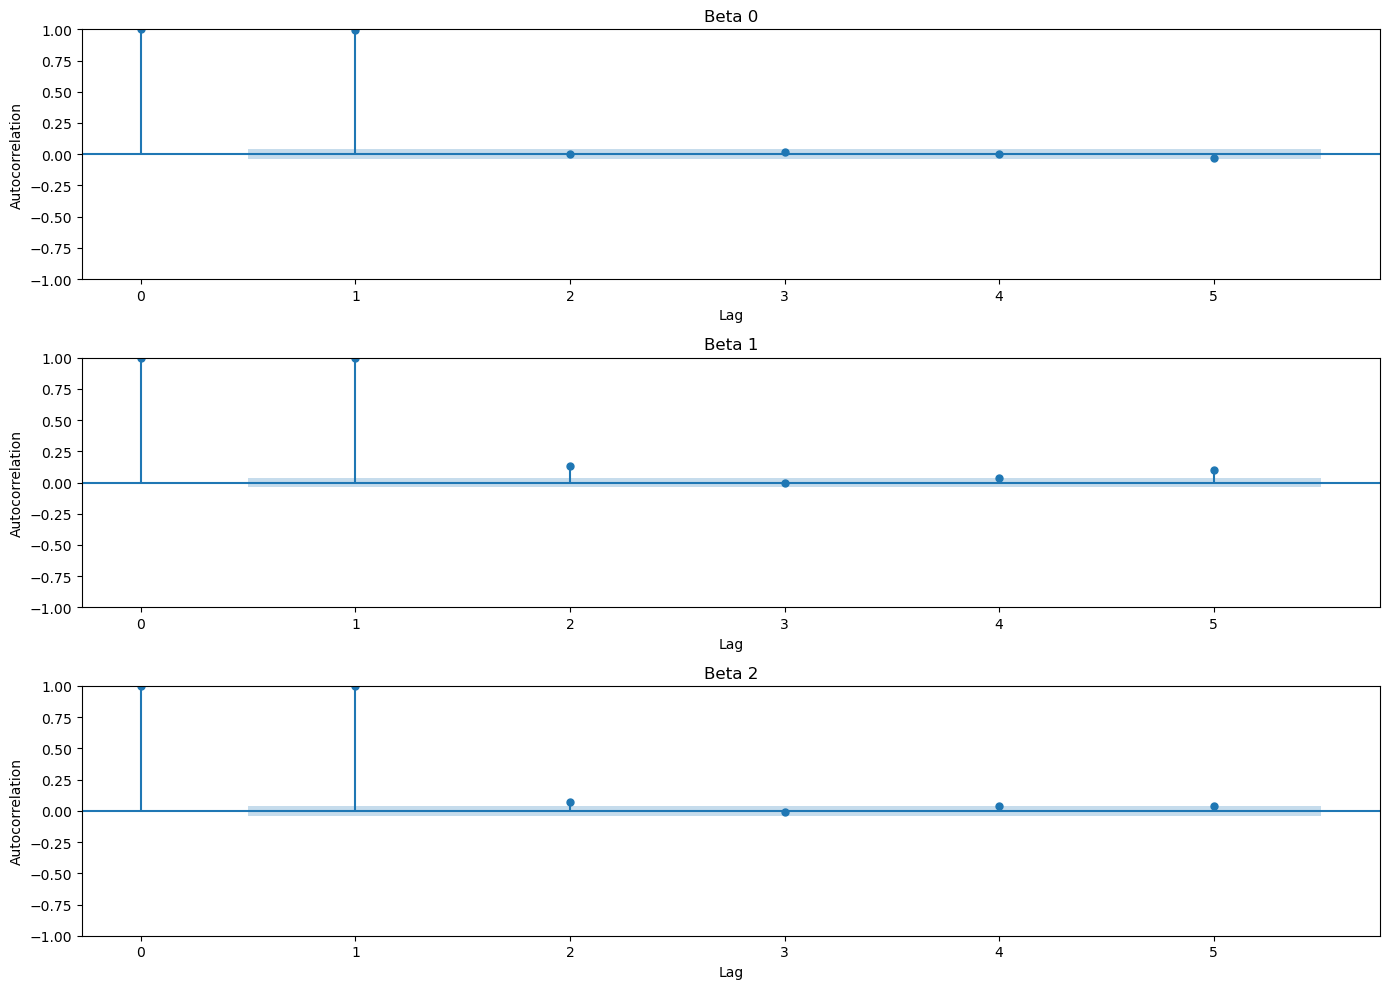

In [119]:
#Partial Auto Correlation
def plotting_partial_auto_correlation(list_plot, position, title):
    # Plot the original data and autocorrelation on the specified subplot position
    plt.subplot(3, 1, position)  # 3 rows, 1 column, current position
    plot_pacf(list_plot, lags=5, ax=plt.gca())  # Plot autocorrelation for 300 lags
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    
# You would call the function like this:
plt.figure(figsize=(14, 10))  # Adjust the figure size as needed
plotting_partial_auto_correlation(fix_beta_0, 1, 'Beta 0')
plotting_partial_auto_correlation(fix_beta_1, 2, 'Beta 1')
plotting_partial_auto_correlation(fix_beta_2, 3, 'Beta 2')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [120]:

def check_mean_reversion(series, name):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[1] < 0.05:
        print("The series " + name + " is likely mean-reverting.")
    else:
        print("The series " + name + " is not likely mean-reverting.")

# Assume 'time_series' is your pandas Series
check_mean_reversion(fix_beta_0, "beta 0")
check_mean_reversion(fix_beta_1, "beta 1")
check_mean_reversion(fix_beta_2, "beta 2")

ADF Statistic: 0.174814
p-value: 0.970813
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 0 is not likely mean-reverting.
ADF Statistic: -2.053067
p-value: 0.263800
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 1 is not likely mean-reverting.
ADF Statistic: -1.554528
p-value: 0.506386
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
The series beta 2 is not likely mean-reverting.


### stationarity

In [121]:

# Assuming 'time_series' is your pandas Series
def check_stationarity(ts,name):
    # Perform Augmented Dickey-Fuller test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(ts, autolag='AIC')  # AIC is used to select the best lag length
    
    result = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        result['Critical Value (%s)' % key] = value
        
    print(result)
    
    # Interpretation
    if result['p-value'] < 0.05:
        print("The series is likely stationary.")
    else:
        print("The series is likely non-stationary.")

# Assume 'time_series' is your pandas Series
check_stationarity(fix_beta_0, "beta 0")
check_stationarity(fix_beta_1, "beta 1")
check_stationarity(fix_beta_2, "beta 2")

Results of Augmented Dickey-Fuller Test:
Test Statistic                    0.174814
p-value                           0.970813
#Lags Used                       12.000000
Number of Observations Used    2509.000000
Critical Value (1%)              -3.432959
Critical Value (5%)              -2.862693
Critical Value (10%)             -2.567384
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -2.053067
p-value                           0.263800
#Lags Used                       26.000000
Number of Observations Used    2495.000000
Critical Value (1%)              -3.432974
Critical Value (5%)              -2.862699
Critical Value (10%)             -2.567387
dtype: float64
The series is likely non-stationary.
Results of Augmented Dickey-Fuller Test:
Test Statistic                   -1.554528
p-value                           0.506386
#Lags Used                       21.000000
Number of Observations Used    2500.000000

### Kalman Filter for the model

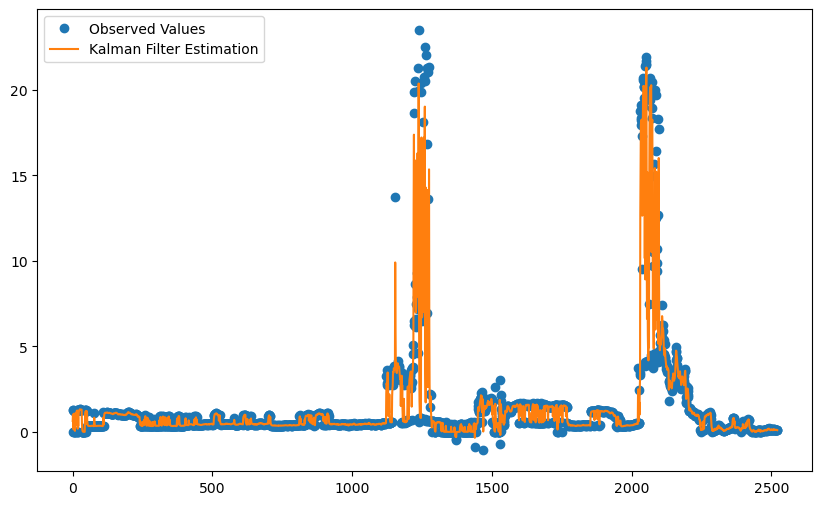

Next value prediction: 0.10283523409594805


0.4946521808603733

In [37]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

# Estimate the hidden states
state_means, state_covariances = kf.filter(lambdas)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(lambdas, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], lambdas[1:])

In [38]:
lambdas

[1.2776861232438654,
 1.2743907248426598,
 -1.5120429650250185e-05,
 -8.053034779743625e-06,
 1.2377160986385198,
 1.221682459580831,
 -9.454951489903341e-06,
 -8.22976502357095e-06,
 -9.129443362075955e-06,
 1.2405072818802227,
 1.2492281405829808,
 -1.5009467393748321e-05,
 1.2434265962272664,
 1.2181730250027392,
 1.243879502560331,
 1.2584248885583977,
 1.2589886529201917,
 -1.7058913475694844e-05,
 -1.742142176410552e-05,
 1.2588631409615323,
 -1.6596980796903456e-05,
 1.3029838136208434,
 1.3006789110762766,
 1.300760977269819,
 1.2962846172821918,
 1.330057004255618,
 1.3227605292244113,
 1.2963951022963547,
 1.2855803735992906,
 1.2953459106913292,
 1.2906137425292505,
 1.3052042628260567,
 1.3029725998020876,
 -1.0913824569606084e-05,
 -9.364696844689869e-06,
 -7.535795623554654e-06,
 -9.772254750758319e-06,
 -1.0327791760434982e-05,
 -1.1626670333344224e-05,
 -1.0354734633879285e-05,
 -1.0019019990073809e-05,
 -9.652593004369762e-06,
 -7.864945067690685e-06,
 -1.6096233633993

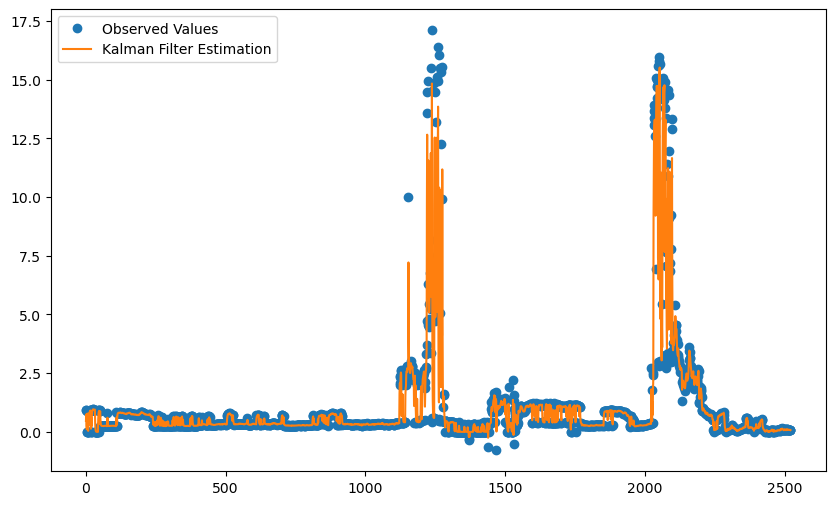

Next value prediction: 0.07490151243799617


0.4946521808603732

In [88]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = lambdas/np.mean(lambdas)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

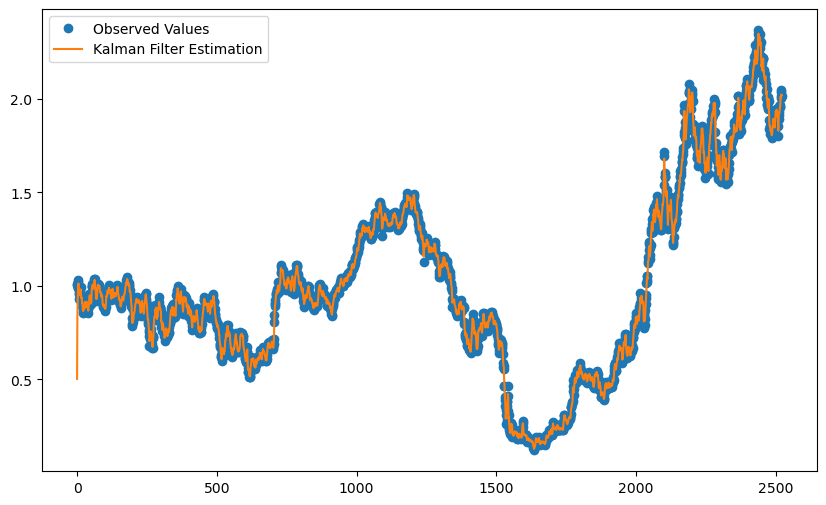

Next value prediction: 2.0194699732282326


0.9959022281879844

In [86]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_0/np.mean(beta_0)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

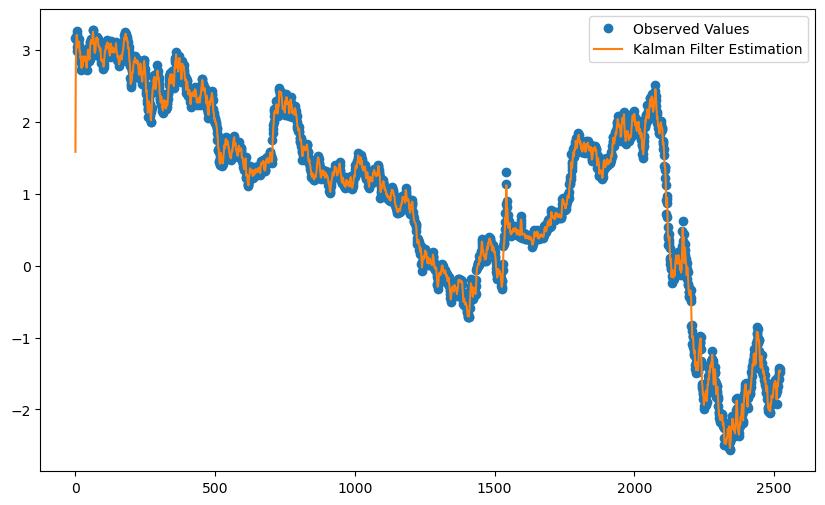

Next value prediction: -1.4745172998108036


0.9965204285858472

In [87]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_1/np.mean(beta_1)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

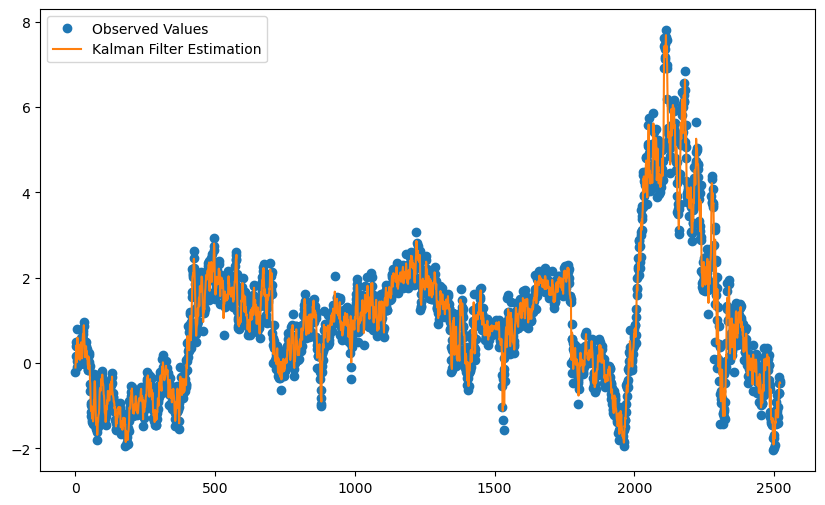

Next value prediction: -0.46415533290424327


0.9568864925336836

In [85]:
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

series = beta_2/np.mean(beta_2)
# Estimate the hidden states
state_means, state_covariances = kf.filter(series)

# Predict the next value (extend this as needed)
next_value, next_covariance = kf.filter_update(state_means[-1], state_covariances[-1], observation=None)
plt.figure(figsize=(10, 6))
#plt.plot(lambdas, label='True Values')
plt.plot(series, 'o', label='Observed Values')
plt.plot(state_means, '-', label='Kalman Filter Estimation')
plt.legend()
plt.show()

print(f"Next value prediction: {next_value[0]}")
r2_score(state_means[:-1], series[1:])

In [71]:
r2_score(state_means[:-1], lambdas[1:])

0.4946521808603733

In [77]:
# It seems I forgot to import numpy before using it. Let's correct that and run the function again.

import numpy as np

def moving_average_with_lag(observations, window_size=5, lag=5):
    """
    Compute the moving average of an array with a specified lag.
    
    Parameters:
    - observations: The input array of observations.
    - window_size: The size of the moving average window.
    - lag: The lag to apply after computing the moving average.
    
    Returns:
    - A numpy array containing the moving averages with the specified lag.
    """
    
    # Compute the moving average
    moving_averages = np.convolve(observations, np.ones(window_size) / window_size, mode='valid')
    
    # Apply the lag
    # Prepend np.nan (or zeros) to the start of the moving averages array to introduce the lag
    lagged_moving_averages = np.concatenate((np.full(lag, np.nan), moving_averages))
    
    # If the lag causes the result to be longer than the original, trim the excess
    if len(lagged_moving_averages) > len(observations):
        lagged_moving_averages = lagged_moving_averages[:len(observations)]
    
    return lagged_moving_averages

n = 3

# Example usage:
observations = lambdas
moving_average_with_lag_result = moving_average_with_lag(observations,n,n)

moving_average_with_lag_result
r2_score(moving_average_with_lag_result[n:], lambdas[n:])

0.5048491511019102

<Axes: >

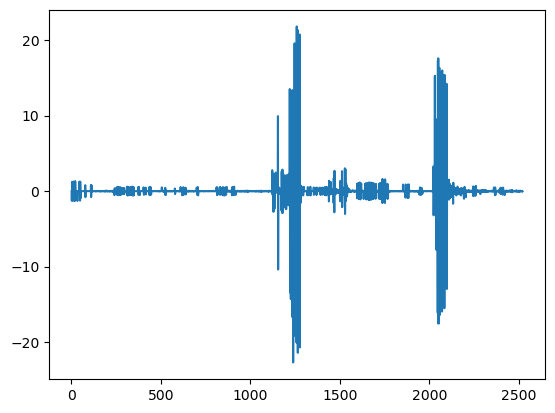

In [79]:
sample_series = pd.Series(lambdas)
sample_series.diff(1).plot()

In [66]:
r2_score(moving_average_with_lag_result[5:], lambdas[5:])

0.4453901321419629

In [39]:

# Assume 'time_series' is your non-stationary pandas Series
# Step 1: Difference the data to make it stationary (determined by ADF test and visual inspection)
# Let's assume we found d=1 is sufficient for stationarity

# Step 2: Determine p and q using ACF and PACF plots (not shown here)
#p and q
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for d in [1,2,3]:
    for q in range(18,23):
        # Step 3: Fit the ARIMA model
        model = ARIMA(beta_0, order=(2, d, q))  # using d=1 as found in step 1
        model_fit = model.fit()
        #model_fit.specification['order']
        if model_fit.aic < best_aic:
            aic_res =  model_fit.specification['order']
            best_aic = model_fit.aic
            
        if model_fit.bic < best_bic:
            bic_res =  model_fit.specification['order']
            best_bix = model_fit.bic
        
        if model_fit.bic + model_fit.aic < combined_bic:
            combined_res =  model_fit.specification['order']
            combined_bic = model_fit.bic + model_fit.aic
            


/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/juliusgruber/anaconda3/envs/MarketMicroStructure/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KeyboardInterrupt: 

In [ ]:
print(bic_res)
print(aic_res)
print(combined_res)

In [ ]:
model = ARIMA(beta_1, order=(2, 1, 19), maxiter=500, method='lbfgs')
model_fit = model.fit()

# Check the summary
print(model_fit.summary())

### Finding Optimal Parameters for Beta 0

### Failing Garch Models

In [ ]:


            
best_aic = 123456789
best_bic = 123456789
combined_bic = 123456789
aic_res = []
bic_res = []
combined_res = []

for q in range(5,25):
    # Specifying a GARCH(1, 1) model
    garch_model = arch_model(beta_1, vol='Garch', p=2, q=q)

    # Fit the model
    garch_fit = garch_model.fit(disp='off')  # disp='off' turns off the convergence output
    if garch_fit.aic < best_aic:
        aic_res =   [2,q]
        best_aic = garch_fit.aic
            
    if garch_fit.bic < best_bic:
        bic_res =  [2,q]
        best_bix = garch_fit.bic
    
    if garch_fit.bic + garch_fit.aic < combined_bic:
        combined_res =   [2,q]
        combined_bic = garch_fit.bic + garch_fit.aic


In [ ]:
print(aic_res)
print(bic_res)
print(combined_res)

In [ ]:

# Specifying a GARCH(1, 1) model
garch_model = arch_model(beta_2, vol='Garch', p=2, q=9)

# Fit the model
garch_model.fit(update_freq=5, disp='off', show_warning=True, tol=1e-6)
print(garch_fit.summary())


### Garch Model not converging

# Predicting with constant lambda

# Task Xiaoliang

@ Xiaoliang: We have the 3 following time series. Can you please try to find an appropiate time series model for them. 
I already applied auto Arima. I think the best idea would be to use either sktime or another method. Have fun finding alpha.

(iii) Can the yield predictions based on the time series properties of the parameters be used for profitable trading?

(i) Using the last 20 % of the data, try to forecast the parameteres in the model. 

(ii) Forecast the next step for the time series.

(iii) Dumb it in the equation, see if they are higher than the current DGS value, go long, else go short.

(iv) Add to position in portfolio in log return space, if it is higher, else go short.

(v) Lock at the lock returns of the portfolio.

(vi) calculate the accuracy in the data, if too fucked up, change signs.

TODO: rething the book calibration



In [165]:
merged_df["beta_0"] = fix_beta_0 
merged_df["beta_1"] = fix_beta_1 
merged_df["beta_2"] = fix_beta_2 
merged_df["lambda"] = op_lam_mse

In [212]:
# Calculate the number of rows for the last 20%
num_rows = len(merged_df)
rows_for_last_20_percent = int(num_rows * 0.2116)

train_split = merged_df.head(num_rows - int(num_rows * 0.2116))
# Select the last 20% of rows
backtest = merged_df.tail(rows_for_last_20_percent)
backtest
train_split

observation_date  DGS3MO  DGS1  DGS2  DGS6MO  DGS3  DGS5  DGS7  DGS10
0          2014-01-02    0.07  0.13  0.39    0.09  0.76  1.72  2.41   3.00
1          2014-01-03    0.07  0.13  0.41    0.10  0.80  1.73  2.42   3.01
2          2014-01-06    0.05  0.12  0.40    0.08  0.78  1.70  2.38   2.98
3          2014-01-07    0.04  0.13  0.40    0.08  0.80  1.69  2.37   2.96
4          2014-01-08    0.05  0.13  0.43    0.08  0.87  1.77  2.44   3.01
...               ...     ...   ...   ...     ...   ...   ...   ...    ...
1984       2021-12-27    0.06  0.33  0.76    0.21  0.98  1.26  1.41   1.48
1985       2021-12-28    0.06  0.39  0.74    0.20  0.99  1.27  1.41   1.49
1986       2021-12-29    0.05  0.38  0.75    0.19  0.99  1.29  1.47   1.55
1987       2021-12-30    0.05  0.38  0.73    0.19  0.98  1.27  1.44   1.52
1988       2021-12-31    0.06  0.39  0.73    0.19  0.97  1.26  1.44   1.52

[1989 rows x 9 columns]

In [169]:
arima_model_lambdas_beta_0 = pm.auto_arima(fix_beta_0, trace=True,max_p=10,max_d=3,max_q=10, stepwise=False, information_criterion='aic')
arima_model_lambdas_beta_1 = pm.auto_arima(fix_beta_1, trace=True,max_p=10,max_d=3,max_q=10, stepwise=False, information_criterion='aic')
arima_model_lambdas_beta_2 = pm.auto_arima(fix_beta_2, trace=True,max_p=10,max_d=3,max_q=10, stepwise=False, information_criterion='aic')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-8464.827, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-8463.728, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-8463.368, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-8461.467, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-8464.033, Time=0.79 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-8463.499, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-8463.680, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-8461.111, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-8460.267, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-8459.505, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-8462.774, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-8463.473, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-8460.787, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-8480.687, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-8477.803, Time=0.99

In [171]:
beta_0_backtest_data = backtest["beta_0"]
for i in eange)

1989    1.127254
1990    1.131821
1991    1.181848
1992    1.215972
1993    1.236514
          ...   
2517    4.546370
2518    4.495926
2519    4.476711
2520    4.534200
2521    4.502740
Name: beta_0, Length: 533, dtype: float64

In [172]:
merged_df

observation_date  DGS3MO  DGS1  DGS2  DGS6MO  DGS10  DGS3  DGS5  DGS7  \
0          2014-01-02    0.07  0.13  0.39    0.09   3.00  0.76  1.72  2.41   
1          2014-01-03    0.07  0.13  0.41    0.10   3.01  0.80  1.73  2.42   
2          2014-01-06    0.05  0.12  0.40    0.08   2.98  0.78  1.70  2.38   
3          2014-01-07    0.04  0.13  0.40    0.08   2.96  0.80  1.69  2.37   
4          2014-01-08    0.05  0.13  0.43    0.08   3.01  0.87  1.77  2.44   
...               ...     ...   ...   ...     ...    ...   ...   ...   ...   
2517       2024-02-13    5.45  4.99  4.64    5.32   4.31  4.44  4.31  4.33   
2518       2024-02-14    5.43  4.94  4.56    5.31   4.27  4.38  4.25  4.27   
2519       2024-02-15    5.43  4.93  4.56    5.30   4.24  4.36  4.22  4.25   
2520       2024-02-16    5.44  4.98  4.64    5.31   4.30  4.43  4.29  4.31   
2521       2024-02-20    5.44  4.97  4.59    5.32   4.27  4.38  4.25  4.28   

        beta_0     beta_1     beta_2  lambda  
0     1.467058  10.494123 -11.909638    5.21  
1     1.484021  10.579962 -12.024096    5.21  
2     1.457989  10.367272 -11.845152    5.21  
3     1.454070  10.132193 -11.681913    5.21  
4     1.506211  10.568329 -12.134354    5.21  
...        ...        ...        ...     ...  
2517  4.546370   0.514423   2.152266    5.21  
2518  4.495926   0.819908   2.006704    5.21  
2519  4.476711   0.779934   2.089705    5.21  
2520  4.534200   0.464016   2.195816    5.21  
2521  4.502740   0.472483   2.280469    5.21  

[2522 rows x 13 columns]

(iv) Develop an ML based (using xgboost, or neural net based) frame- work of analysis of the parameters leading to a profitable strategy?

(v) Can the yield predictions based on the ML approach lead to prof- itable trading?